# Análisis de Sentimientos con NLTK VADER
## Análisis de reseñas de productos de Amazon

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/WillianReinaG/PNL_unidad1/blob/main/2_Analisis_Sentimientos_VADER.ipynb)

Este notebook realiza un análisis completo de sentimientos utilizando NLTK con VADER.

## 1. Introducción a VADER

**VADER** es un modelo basado lexicón y herramienta de análisis optimizada para redes sociales.
Características:
- Combina enfoques léxico y reglas
- Excelente para textos cortos
- Produce 4 scores: neg, neu, pos, compound
- Compound score (-1 a +1) resume el sentimiento total

## 2. Instalación de dependencias
Se instalarán las librerías necesarias para correr todo el notebook.

In [ ]:
!pip install nltk scikit-learn pandas numpy matplotlib seaborn -q
import nltk
nltk.download("vader_lexicon", quiet=True)
nltk.download("punkt", quiet=True)
print("✓ Dependencias instaladas")

✓ Dependencias instaladas


## 3. Importar librerías
Se importarán paquetes para manipular datos, aplicar VADER, evaluar y graficar.

In [ ]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
sia = SentimentIntensityAnalyzer()
print("✓ Librerías importadas")

✓ Librerías importadas


## 4. Cargar datos
Anuncia la carga del dataset de reseñas y su etiqueta de sentimiento.

In [ ]:
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
if IN_COLAB:
    !wget https://raw.githubusercontent.com/WillianReinaG/PNL_unidad1/main/amazon_cells_labelled.txt -O ./amazon_cells_labelled.txt
with open("./amazon_cells_labelled.txt", "r", encoding="utf-8") as file:
    df = pd.read_csv(file, sep="\t", header=None, names=["review", "sentiment"])
print(f"Reseñas cargadas: {len(df)}")
print(f"Positivas: {(df['sentiment'] == 1).sum()} | Negativas: {(df['sentiment'] == 0).sum()}")

--2026-02-22 23:22:39--  https://raw.githubusercontent.com/WillianReinaG/PNL_unidad1/main/amazon_cells_labelled.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58226 (57K) [text/plain]
Saving to: ‘./amazon_cells_labelled.txt’

./amazon_cells_labe 100%[===================>]  56.86K  --.-KB/s    in 0.01s   

2026-02-22 23:22:39 (5.06 MB/s) - ‘./amazon_cells_labelled.txt’ saved [58226/58226]

Reseñas cargadas: 1000
Positivas: 500 | Negativas: 500


## 5. Exploración de datos
Se hará un resumen rápido del dataset.

In [ ]:
print("Información del dataset:")
print("-" * 50)
print(f"Total de reseñas: {len(df)}")
print(f"Palabras promedio por reseña: {df['review'].str.split().str.len().mean():.1f}")
print(f"\nDistribución de sentimientos:")
print(df['sentiment'].value_counts())
print(f"\nPorcentajes:")
print(f"Positivas: {(df['sentiment'] == 1).sum() / len(df) * 100:.2f}%")
print(f"Negativas: {(df['sentiment'] == 0).sum() / len(df) * 100:.2f}%")

Información del dataset:
--------------------------------------------------
Total de reseñas: 1000
Palabras promedio por reseña: 10.2

Distribución de sentimientos:
sentiment
0    500
1    500
Name: count, dtype: int64

Porcentajes:
Positivas: 50.00%
Negativas: 50.00%


## 6. Limpieza de datos
preprocesamiento para mejorar la estabilidad del análisis.

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s.!?,-]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text
df['review_cleaned'] = df['review'].apply(clean_text)
df = df[df['review_cleaned'].str.len() > 0]
print(f"Reseñas después de limpieza: {len(df)}")

Reseñas después de limpieza: 1000


## 7. Análisis VADER
Cálculo de scores de polaridad por reseña.

In [ ]:
sentiment_scores = df['review_cleaned'].apply(lambda x: sia.polarity_scores(x))
sentiment_df = pd.DataFrame(sentiment_scores.tolist())
df = pd.concat([df, sentiment_df], axis=1)
df = df.rename(columns={"neg": "vader_negative", "neu": "vader_neutral", "pos": "vader_positive", "compound": "vader_compound"})
print("✓ Análisis VADER completado")
print(f"Compound score - min: {df['vader_compound'].min():.3f}, max: {df['vader_compound'].max():.3f}")

✓ Análisis VADER completado
Compound score - min: -0.925, max: 0.954


## 8. Convertir scores a predicciones
Se convertirá compound a etiqueta (0/1) con un umbral.

In [ ]:
df['vader_prediction'] = df['vader_compound'].apply(lambda x: 1 if x >= 0.05 else 0)
print("Distribución de predicciones:")
print(df['vader_prediction'].value_counts())
print(f"\nPositivas predichas: {(df['vader_prediction'] == 1).sum() / len(df) * 100:.2f}%")

Distribución de predicciones:
vader_prediction
0    516
1    484
Name: count, dtype: int64

Positivas predichas: 48.40%


## 9. Métricas de evaluación
Evaluación comparando etiqueta real vs predicción VADER.

In [ ]:
y_true = df['sentiment'].values
y_pred = df['vader_prediction'].values
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
print("=" * 60)
print("MÉTRICAS DE CALIDAD")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

MÉTRICAS DE CALIDAD
Accuracy:  0.8340 (83.40%)
Precision: 0.8450
Recall:    0.8180
F1-Score:  0.8313


## 10. Matriz de confusión
Conteo detallado de aciertos/errores por clase.

In [ ]:
cm = confusion_matrix(y_true, y_pred)
print("Matriz de Confusión:")
print("Predicción Negativo | Predicción Positivo")
print(f"Real Negativo: {cm[0,0]:>6} | {cm[0,1]:>6}")
print(f"Real Positivo: {cm[1,0]:>6} | {cm[1,1]:>6}")
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=["Negativo", "Positivo"]))

Matriz de Confusión:
Predicción Negativo | Predicción Positivo
Real Negativo:    425 |     75
Real Positivo:     91 |    409

Reporte de clasificación:
              precision    recall  f1-score   support

    Negativo       0.82      0.85      0.84       500
    Positivo       0.85      0.82      0.83       500

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



## 11. Visualización: Matriz de confusión
Heatmap para interpretar mejor el comportamiento del modelo.


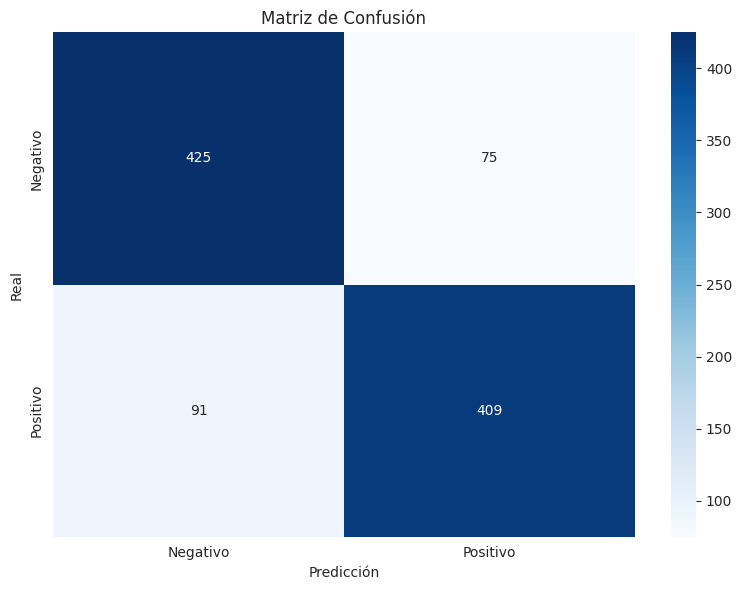

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.title("Matriz de Confusión")
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.tight_layout()
plt.show()

## 12. Visualización: Distribución de scores
Grafica la matriz de confusión como mapa de calor para identificar fácilmente dónde se equivoca más VADER.
Indica que se observará cómo se distribuye el score global y cómo separa las clases.


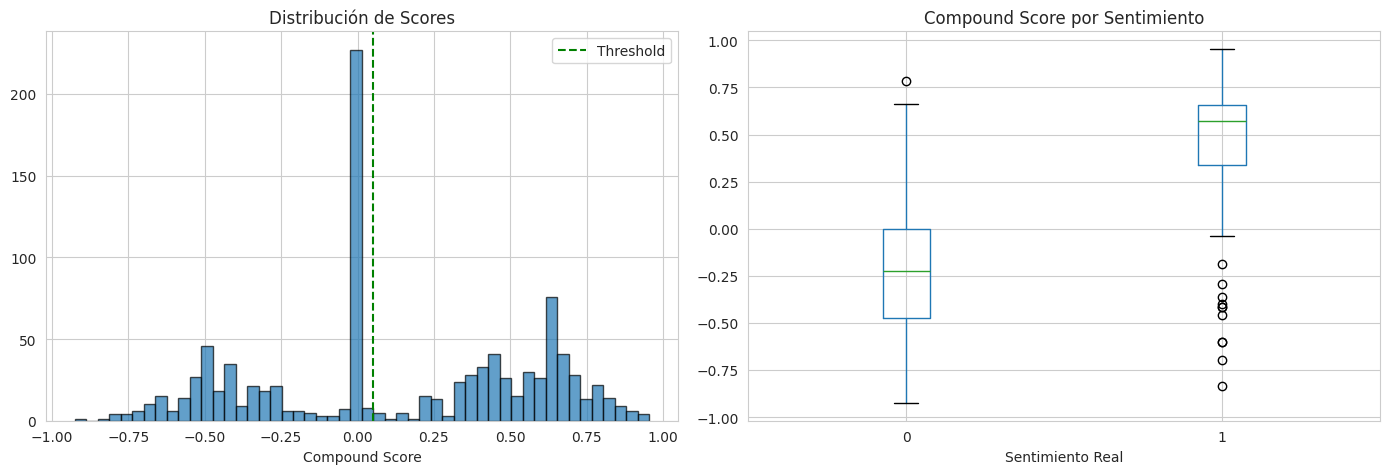

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['vader_compound'], bins=50, edgecolor="black", alpha=0.7)
axes[0].axvline(x=0.05, color="green", linestyle="--", label="Threshold")
axes[0].set_xlabel("Compound Score")
axes[0].set_title("Distribución de Scores")
axes[0].legend()
df.boxplot(column="vader_compound", by="sentiment", ax=axes[1])
axes[1].set_xlabel("Sentimiento Real")
axes[1].set_title("Compound Score por Sentimiento")
plt.suptitle("")
plt.tight_layout()
plt.show()

## 13. Visualización: Componentes VADER
Presenta el análisis desagregado de las tres componentes.

Muestra cómo se distribuyen los puntajes parciales de negatividad, neutralidad y positividad.

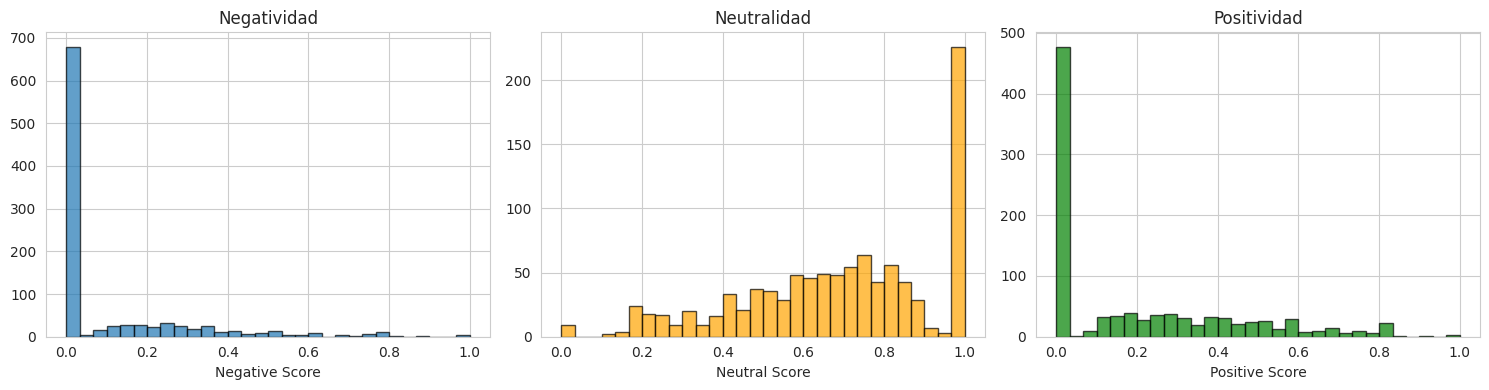

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(df['vader_negative'], bins=30, alpha=0.7, edgecolor="black")
axes[0].set_title("Negatividad")
axes[0].set_xlabel("Negative Score")
axes[1].hist(df['vader_neutral'], bins=30, alpha=0.7, edgecolor="black", color="orange")
axes[1].set_title("Neutralidad")
axes[1].set_xlabel("Neutral Score")
axes[2].hist(df['vader_positive'], bins=30, alpha=0.7, edgecolor="black", color="green")
axes[2].set_title("Positividad")
axes[2].set_xlabel("Positive Score")
plt.tight_layout()
plt.show()

## 14. Preparación para análisis de palabras
se separarán reseñas positivas/negativas para contar palabras frecuentes.

Une todas las reseñas positivas en un solo string y lo mismo con negativas.

Tokeniza con word_tokenize.

Cuenta palabras con Counter, filtrando:

longitud > 2

solo alfabéticas

In [ ]:
nltk.download("punkt_tab", quiet=True)
positive_reviews = " ".join(df[df['sentiment'] == 1]['review_cleaned'].tolist())
negative_reviews = " ".join(df[df['sentiment'] == 0]['review_cleaned'].tolist())
positive_words = word_tokenize(positive_reviews)
negative_words = word_tokenize(negative_reviews)
positive_freq = Counter([w for w in positive_words if len(w) > 2 and w.isalpha()])
negative_freq = Counter([w for w in negative_words if len(w) > 2 and w.isalpha()])
print("✓ Análisis de palabras preparado")

✓ Análisis de palabras preparado


## 15. Palabras más frecuentes


In [ ]:
print("Palabras más frecuentes en RESEÑAS POSITIVAS:")
print("-" * 50)
for i, (word, freq) in enumerate(positive_freq.most_common(15), 1):
    print(f"{i:2d}. {word:15s} - {freq:4d} veces")
print("\n\nPalabras más frecuentes en RESEÑAS NEGATIVAS:")
print("-" * 50)
for i, (word, freq) in enumerate(negative_freq.most_common(15), 1):
    print(f"{i:2d}. {word:15s} - {freq:4d} veces")

Palabras más frecuentes en RESEÑAS POSITIVAS:
--------------------------------------------------
 1. the             -  237 veces
 2. and             -  188 veces
 3. this            -  105 veces
 4. great           -   93 veces
 5. phone           -   86 veces
 6. very            -   69 veces
 7. for             -   66 veces
 8. with            -   65 veces
 9. good            -   62 veces
10. works           -   46 veces
11. have            -   38 veces
12. was             -   36 veces
13. product         -   33 veces
14. that            -   32 veces
15. well            -   32 veces


Palabras más frecuentes en RESEÑAS NEGATIVAS:
--------------------------------------------------
 1. the             -  277 veces
 2. and             -  122 veces
 3. not             -  106 veces
 4. this            -  102 veces
 5. phone           -   76 veces
 6. for             -   55 veces
 7. was             -   54 veces
 8. that            -   48 veces
 9. you             -   47 veces
10. with    

## 16. Análisis de errores

In [ ]:
df['correct'] = df['sentiment'] == df['vader_prediction']
misclassified = df[~df['correct']]
fp = misclassified[(misclassified['sentiment'] == 0) & (misclassified['vader_prediction'] == 1)]
fn = misclassified[(misclassified['sentiment'] == 1) & (misclassified['vader_prediction'] == 0)]
print("ANÁLISIS DE ERRORES")
print("=" * 70)
print(f"Correctas: {(df['correct']).sum()} ({(df['correct']).sum()/len(df)*100:.2f}%)")
print(f"Incorrectas: {len(misclassified)} ({len(misclassified)/len(df)*100:.2f}%)")
print(f"  - Falsos Positivos: {len(fp)}")
print(f"  - Falsos Negativos: {len(fn)}")
print("\nEjemplos de FALSOS POSITIVOS:")
for idx in fp.head(2).index:
    print(f"  {df.loc[idx, 'review'][:60]}... | Score: {df.loc[idx, 'vader_compound']:.3f}")
print("\nEjemplos de FALSOS NEGATIVOS:")
for idx in fn.head(2).index:
    print(f"  {df.loc[idx, 'review'][:60]}... | Score: {df.loc[idx, 'vader_compound']:.3f}")

ANÁLISIS DE ERRORES
Correctas: 834 (83.40%)
Incorrectas: 166 (16.60%)
  - Falsos Positivos: 75
  - Falsos Negativos: 91

Ejemplos de FALSOS POSITIVOS:
  If you have several dozen or several hundred contacts, then ... | Score: 0.511
  I advise EVERYONE DO NOT BE FOOLED!... | Score: 0.356

Ejemplos de FALSOS NEGATIVOS:
  If you are Razr owner...you must have this!... | Score: 0.000
  So Far So Good!.... | Score: 0.000


## 17. Conclusiones

In [ ]:
print("\n" + "=" * 70)
print("RESUMEN FINAL")
print("=" * 70)
print(f"Dataset analizado: {len(df)} reseñas")
print(f"Modelo: VADER")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"\nVentajas VADER:")
print("  ✓ Excelente para textos cortos")
print("  ✓ Maneja emojis y puntuación")
print("  ✓ Rápido sin entrenamiento")
print(f"\nLimitaciones:")
print("  ✗ Pueden no captar sarcasmo")
print("  ✗ Menor desempeño en textos largos")